# Kaggle: Allstate Claims Severity

Kaggle Problem: [Allstate Claims Severity](https://www.kaggle.com/c/allstate-claims-severity/overview)

Objective: predict the loss cost associated with insurance claim data

Evaluation metric: mean absolute error

Modeling methods: 
- individually fit LightGBM, XGBoost, and Keras regression models
- predictions from these regression models were then combined as both a voting ensemble and a stacking ensemble

Results:
- My best fitting single model was LightGBM with a private leaderboard score of 1135.47485 (top 47%).
- An average of the predictions from LightGBM, XGBoost, and Keras models scored 1129.37730 (top 37%).
- A stacking ensemble using a Ridge meta-model scored 1128.77685 (top 36%).


# Organization:

1. [The data](#section_1) 
    1. [Reading in training and test data](#section_1.1)  
    + [Numerical and categorical features](#section_1.2) 

+ [Data cleaning](#section_2)
    1. [Missing data](#section_2.1)  
    + [Encoding categorical data](#section_2.2)  

+ [Exploratory data analysis](#section3) 
    1. [Distribution of the target variable](#section_3.1)  
    + [Multivariate analysis](#section_3.2)
        1. [Feature (numerical) - Target Correlation](#section_3.2.1)  
        + [Feature (categorical) - Target Correlation](#section_3.2.2)  
        
+ [Feature engineering](#section4)
    1. [Interaction terms](#section_4.1)  
    + [Polynomials](#section_4.2)   
    + [Summary of new created features](#section_4.3)   
    
+ [Data pre-processing](#section_5)
    1. [Skewed features and log transforms](#section_5.1)  
    + [Multicollinearity](#section_5.2)  
    + [Final prepping of the data before modeling](#section_5.3)   
    
+ [Modeling](#section_6)
    1. [LGBMRegressor](#section_6.1)   
    + [XGBRegressor](#section_6.2)   
    + [Keras](#section_6.3)    

+ [Model ensembling](#section_7)
    1. [Comparing model fits](#section_7.1)   
    + [Voting ensemble](#section_7.2)    
    + [Stacking ensemble](#section_7.3)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1. The Data <a id='section_1'></a>
- [1.1 Reading in training and test data](#section_1.1)  
- [1.2 Numerical and categorical features](#section_1.2)   

## 1.1 Reading in training and test data <a id='section_1.1'></a>


In [2]:
# Read in the training and test data sets
X = pd.read_csv('./input/train.csv', index_col='id')  # training data
X_test = pd.read_csv('./input/test.csv', index_col='id')  # test data

# Remove any rows from the training set where there is no target
X.dropna(axis=0, subset=['loss'], inplace=True)

# Separate out the target in the training set
y0 = X['loss'].copy() # target
y = np.log1p(y0)

X['loss'] = y

In [3]:
X.head()

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
id,,,,,,,,,,,,,,,,,,,,,
1,A,B,A,B,A,A,A,A,B,A,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,7.702637
2,A,B,A,A,A,A,A,A,B,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,7.158203
5,A,B,A,A,B,A,A,A,B,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,8.008396
10,B,B,A,B,A,A,A,A,B,A,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,6.846784
11,A,B,A,B,A,A,A,A,B,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,7.924742


In [4]:
X.shape

(188318, 131)

In [5]:
# Combining train and test data sets
X_all = pd.concat([X, X_test], axis=0, sort=False)

## 1.2 Numerical and categorical features <a id='section_1.2'></a>

In [6]:
X_all.dtypes

cat1       object
cat2       object
cat3       object
cat4       object
cat5       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 131, dtype: object

In [7]:
# Categorical features
cat_cols = list(X.filter(regex='^cat',axis=1).columns)

# Numerical features
num_cols = list(X.filter(regex='^cont',axis=1).columns)

print('Numerical features:\n', num_cols)
print()
print('Categorical features:\n', cat_cols)

Numerical features:
 ['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']

Categorical features:
 ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'ca

# 2. Data Cleaning <a id='section_2'></a>

[2.1 Missing data](#section_2.1)  
[2.2 Encoding categorical data](#section_2.2)   

## 2.1 Missing data <a id='section_2.1'></a>

In [8]:
# Missing data
for col in X.columns:
    if X[col].isnull().any():
        print(col, sum(X[col].isnull()))

No missing data.

## 2.2 Encoding categorical data <a id='section_2.2'></a>

In [9]:
import category_encoders as ce

enc = ce.TargetEncoder().fit(X_all[:X.shape[0]].drop('loss', axis=1),y)
X_all = enc.transform(X_all.drop('loss',axis=1))

# 3. Exploratory data analysis <a id='section_3'></a>

[3.1 Distribution of the target variable](#section_3.1)  

[3.2 Multivariate analysis](#section_3.2)
- [3.2.1 Feature (numerical) - Target Correlation](#section_3.2.1)  
- [3.2.2 Feature (categorical) - Target Correlation](#section_3.2.2)  


## 3.1 Distribution of the target variable  <a id='section_3.1'></a>

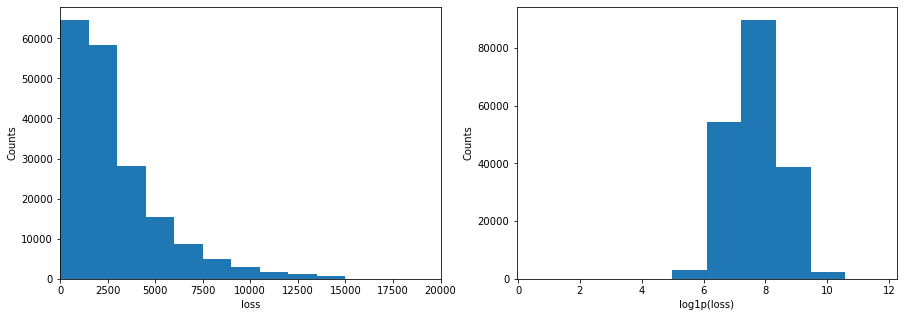

In [10]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(y0[y0<15000])
plt.xlim(0,20000)
plt.xlabel('loss')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.hist(np.log1p(y0))
plt.xlabel('log1p(loss)')
plt.ylabel('Counts');

A log transform of the target variable makes it more normally distributed. This transform significantly improves model performance.

## 3.2 Multivariate analysis <a id='section_3.2'></a>
Which features are most strongly correlated to the target variable?

### 3.2.1 Feature (numerical) - Target Correlation <a id='section_3.2.1'></a>

In [11]:
# Numerical features with greatest correlation to target

# Calculate pearson correlation between target and numeric features
corr = X[num_cols].corrwith(y)
print(corr.sort_values(ascending=False)[:10])
print(corr.sort_values(ascending=False)[-3:])

# List of features most strongly correlated with target
corr_top = list(np.abs(corr).sort_values(ascending=False)[:8].keys())

cont2     0.104666
cont7     0.085095
cont3     0.081548
cont11    0.072760
cont12    0.072266
cont8     0.032042
cont6     0.031517
cont14    0.025948
cont9     0.017417
cont10    0.010604
dtype: float64
cont1   -0.007335
cont5   -0.014958
cont4   -0.027523
dtype: float64


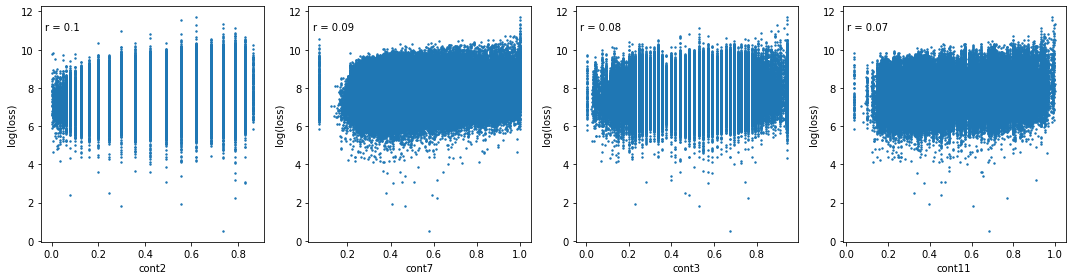

In [12]:
# Scatter plots for the features most correlated with the target variable

fig = plt.figure(figsize=(15, 4)) # (width,height)
for index, col in enumerate(corr_top[:4]):
    ax = fig.add_subplot(1, 4, index+1)
    plt.scatter(X[col], y, s=2)
    c = np.round(X[col].corr(y),decimals=2) # correlation with target for feature
    plt.annotate('r = '+str(c), (0.02,0.9), xycoords='axes fraction')
    plt.xlabel(col)
    plt.ylabel('log(loss)')
plt.tight_layout()

The numeric features are only weakly correlated with the target variable. The strongest correlation occurs between 'cont2' and the target (r = 0.1).

### 3.2.2 Feature (categorical) - Target "Correlation" <a id='section_3.2.2'></a>
Very useful resource: [An overview of correlation measures between categorical and continuous variables](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [13]:
# Kruskal-Wallis H-test
from scipy import stats

df_kruskal = pd.DataFrame(columns=['col','f','p'])
for index, col in enumerate(cat_cols):
    f, p = stats.kruskal(*[y.loc[X[X[col]==x].index] for x in set(X[col])])
    df_kruskal = df_kruskal.append({'col': col , 'f': f, 'p': p} , ignore_index=True)
df_kruskal = df_kruskal.sort_values(by='f', ascending=False)
df_kruskal.head()


,col,f,p
79,cat80,43584.256807,0.0
78,cat79,30002.995538,0.0
100,cat101,27404.608738,0.0
99,cat100,26549.483536,0.0
11,cat12,21534.274877,0.0


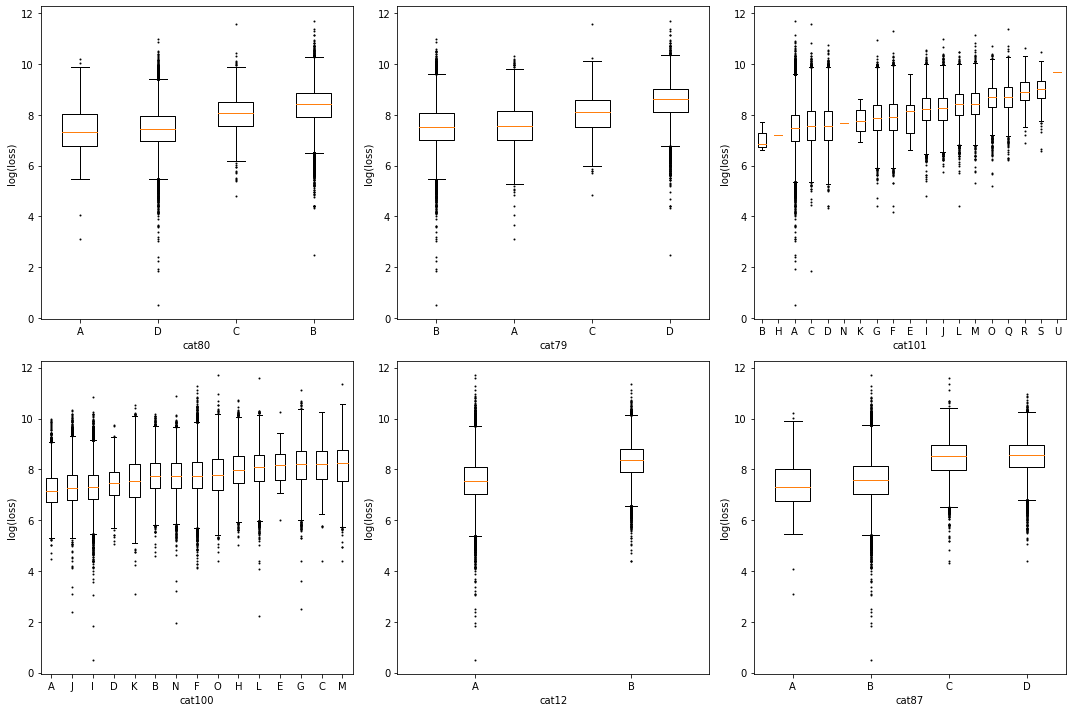

In [14]:
# Boxplots for those features with highest kruskal score

fig = plt.figure(figsize=(15, 10)) # (width,height)

outlier_marker = dict(markerfacecolor='k', marker='.', markersize=2)

for index, col in enumerate(df_kruskal['col'][:6]):
    ax = fig.add_subplot(2, 3, index+1)

    data = []
    x_vals =X[col].unique()
    med_list = []
    for x in x_vals:
        yy = y[X[col]==x].dropna(axis=0).values
        data.append(yy)
        med_list.append(np.median(yy))
        
    df_plot = pd.DataFrame({'x_vals': x_vals, 'median': med_list, 'data': data})
    df_plot = df_plot.sort_values(by='median')
    
    plt.boxplot(df_plot['data'], flierprops=outlier_marker)
    
    locs=ax.get_xticks()
    plt.xticks(locs, df_plot['x_vals'])

    plt.xlabel(col)
    plt.ylabel('log(loss)')
plt.tight_layout()

# 4. Feature Engineering <a id='section_4'></a>

- [4.1 Interaction terms](#section_4.1)  
- [4.2 Polynomials](#section_4.2)   
- [4.3 Summary of new created features](#section_4.3)   

## 4.1 Multiplicative interaction terms <a id='section_4.1'></a>

The insurance claim data has been anonymized so that no information is included in the names of the numerical and categorical features. With no sense of what the features are representing, there are no immediate ways to create new features using domain knowledge. However, numerical features that have a high correlation to the target, and categorical features that have a high Kruskal-Wallis H score with the target, are good candidates for being important to predicting the target variable. Thus, here I create new interaction terms by combining some of these potentially important features together.

Overall, this seemed to be a good strategy for feature engineering because many of these multiplicative interaction terms were in the top most important features after fitting my regression models.


In [15]:
# Multiplying together the categorical features with the highest kruskal-wallis score

interact_cols = list(df_kruskal['col'][:15].values)
for ii,col in enumerate(interact_cols):
    if ii==len(interact_cols)-1:
        break
    for jj in np.arange(ii+1,len(interact_cols),1):
        X_all[str(interact_cols[ii])+str(interact_cols[jj])+'_interact'] = \
            X_all[str(interact_cols[ii])]*X_all[str(interact_cols[jj])]

In [16]:
# Multiplying together the numerical features most correlated to the target 
#   with the highest kruskal score categorical features

corr = X[num_cols].corrwith(y)
corr_top = list(np.abs(corr).sort_values(ascending=False)[:5].keys())
for numcol in corr_top:
    for catcol in interact_cols:
        X_all[numcol+catcol+'_interact'] = X_all[numcol]*X_all[catcol]

In [17]:
# Multiplying together the numeric features with the strongest correlations to the target variable

corr = X[num_cols].corrwith(y)
corr_top = list(np.abs(corr).sort_values(ascending=False)[:5].keys())

for ii,col in enumerate(corr_top):
    if ii==len(corr_top)-1:
        break
    for jj in np.arange(ii+1,len(corr_top),1):
        X_all[str(corr_top[ii])+str(corr_top[jj])+'_interact'] = \
            X_all[str(corr_top[ii])]*X_all[str(corr_top[jj])]

## 4.2 Polynomials <a id='section_4.2'></a>
Creating polynomial features for the numeric features with the greatest correlation to the target variable.

In [18]:
# Features with greatest correlation to target

# Calculate pearson correlation between target and numerical features
corr = X[num_cols].corrwith(y) #old

# List of features most strongly correlated with target
corr_top = list(np.abs(corr).sort_values(ascending=False)[:3].keys())
print('Creating polynomial features for:', corr_top)

# Add polynomial features to training and test data sets
for feature in corr_top:
    X_all[feature+'_2'] = X_all[feature]**2.
    X_all[feature+'_3'] = X_all[feature]**3.
    X_all[feature+'_sqrt'] = X_all[feature]**0.5

Creating polynomial features for: ['cont2', 'cont7', 'cont3']


## 4.3 Summary of new created features <a id='section_4.3'></a>

In [19]:
# New features list
new_cols = list(set(X_all.columns)-set(X.columns))


# New categorical features
cat_cols_new = list(set([col for col in new_cols if X_all[col].dtype == "object"])-set(cat_cols))

# New numerical features
num_cols_new = list(set([col for col in new_cols if X_all[col].dtype in ['int64', 'float64']])-set(num_cols))


In [20]:
# Separate train and test data...
X_new = X_all[:X.shape[0]]#.drop('loss', axis=1)
X_test_new = X_all[X.shape[0]:]#.drop('loss', axis=1)
print('Check train and test indicies match originals:', set(X_new.index==X.index), set(X_test_new.index==X_test.index))

Check train and test indicies match originals: {True} {True}


In [21]:
print('X_new shape:', X_new.shape)
print('X_test_new shape:', X_test_new.shape)

X_new shape: (188318, 329)
X_test_new shape: (125546, 329)


# 5. Data pre-processing <a id='section_5'></a>
Final data preparations before modeling:  
[5.1 Skewed features and log transforms](#section_5.1)  
[5.2 Multicollinearity](#section_5.2)  
[5.3 Final prepping of the data before modeling](#section_5.3)  

## 5.1 Skewed features and log transforms <a id='section_5.1'></a>

In [22]:
# Make sure all categorical features are encoded

enc = ce.TargetEncoder().fit(X_new,y)
X_enc = enc.transform(X_new)
X_test_enc = enc.transform(X_test_new)

In [23]:
# Take log transforms of all features for multicollinearity analysis

X_enc = np.log1p(X_enc)
X_test_enc = np.log1p(X_test_enc)

## 5.2 Multicollinearity <a id='section_5.2'></a>
Determine which pairs of features are collinear and only keep the feature of the pair that is most correlated with the target variable.

In [24]:
# Identify features with highest collinearity

corr = X_enc.corr()
df_corr = pd.DataFrame(columns=['feat1','feat2','corr(feat1,feat2)'])
corr_high = corr[(np.abs(corr)<1.)&(np.abs(corr)>0.95)]
for col in corr_high.columns: 
    if corr_high[col].count()>0:
        dat = corr_high[col]
        for ii in range(0,len(dat[dat.notnull()].keys())):
            df_corr = df_corr.append({'feat1': col,
                                      'feat2': dat[dat.notnull()].keys()[ii], 
                                      'corr(feat1,feat2)': dat[dat.notnull()].values[ii]}, 
                                      ignore_index=True)
cols_collinear = df_corr['feat1'].unique()
df_corr = df_corr.sort_values(by='corr(feat1,feat2)', ascending=False).drop_duplicates(subset='corr(feat1,feat2)', keep='first')

In [25]:
# For correlated pairs of features, keep the feature that is more correlated with the target variable

corr_target = X_enc.corrwith(y)[list(cols_collinear)]

feat_better = []
feat_worse = []
feat_better_corr = []
feat_worse_corr = []
for ii in range(0,len(df_corr)):
    feat1 = df_corr.iloc[ii]['feat1']
    feat2 = df_corr.iloc[ii]['feat2']
    feat1_corr = corr_target[feat1]
    feat2_corr = corr_target[feat2]
    if np.abs(feat1_corr) > np.abs(feat2_corr):
        feat_better.append(feat1)
        feat_worse.append(feat2)
        feat_better_corr.append(feat1_corr)
        feat_worse_corr.append(feat2_corr)
    else:
        feat_better.append(feat2)
        feat_worse.append(feat1)
        feat_better_corr.append(feat2_corr)
        feat_worse_corr.append(feat1_corr)
df_corr['feat_better'] = feat_better 
df_corr['feat_worse'] = feat_worse
df_corr['corr(feat_better,target)'] = feat_better_corr # correlation of better feature to the target
df_corr['corr(feat_worse,target)'] = feat_worse_corr # correlation of worse feature to the target

In [26]:
df_corr

,feat1,feat2,"corr(feat1,feat2)",feat_better,feat_worse,"corr(feat_better,target)","corr(feat_worse,target)"
310,cont2cat2_interact,cont2cat9_interact,0.999810,cont2cat2_interact,cont2cat9_interact,0.131893,0.130355
805,cont3cat2_interact,cont3cat9_interact,0.999776,cont3cat2_interact,cont3cat9_interact,0.092117,0.090561
1253,cont11cat9_interact,cont11cat2_interact,0.999763,cont11cat2_interact,cont11cat9_interact,0.082852,0.081201
1685,cont12cat2_interact,cont12cat9_interact,0.999762,cont12cat2_interact,cont12cat9_interact,0.082137,0.080482
559,cont7cat2_interact,cont7cat9_interact,0.999618,cont7cat2_interact,cont7cat9_interact,0.097930,0.095871
...,...,...,...,...,...,...,...
953,cont11cat79_interact,cont11cont12_interact,0.956777,cont11cat79_interact,cont11cont12_interact,0.105880,0.075953
1908,cont7_2,cont7cat80_interact,0.956241,cont7cat80_interact,cont7_2,0.145294,0.088666
1873,cont11cont12_interact,cont12cat80_interact,0.955637,cont12cat80_interact,cont11cont12_interact,0.119934,0.075953
921,cont11cat80_interact,cont11cont12_interact,0.955053,cont11cat80_interact,cont11cont12_interact,0.120551,0.075953


In [27]:
# List of columns to remove based on collinearity analysis
drop_collinear = list(set(cols_collinear)-(set(df_corr['feat_better'])-set(df_corr['feat_worse'])))
len(drop_collinear)

107

## 5.3 Final prepping of the data before modeling <a id='section_5.3'></a>

In [28]:
import category_encoders as ce
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler


X_clean = X_new.copy()
y_clean = y.copy()
X_test_clean = X_test_new.copy()

# Performing encoding
enc = ce.TargetEncoder().fit(X_clean[cat_cols],y)
X_clean[cat_cols] = enc.transform(X_clean[cat_cols])
X_test_clean[cat_cols] = enc.transform(X_test_clean[cat_cols])

# Transforming skewed columns 
X_clean = np.log1p(X_clean) 
X_test_clean = np.log1p(X_test_clean) 
    
# Removing collinear columns
cols_remove = drop_collinear
X_clean = X_clean.drop(cols_remove, axis=1)
X_test_clean = X_test_clean.drop(cols_remove, axis=1)

# Scaling the data
scaler = StandardScaler().fit(X_clean)
X_clean[X_clean.columns] = scaler.transform(X_clean)
X_test_clean[X_test_clean.columns] = scaler.transform(X_test_clean)

# Revising list of features to take into account the addition of new features
num_cols_final = [x for x in list(set(list(num_cols)+list(num_cols_new))-set(cols_remove)) if x in X_clean.columns]
cat_cols_final = [x for x in list(set(list(cat_cols)+list(cat_cols_new))-set(cols_remove)) if x in X_clean.columns]

In [29]:
print('X_clean shape:', X_clean.shape)
print('X_test_clean shape:', X_test_clean.shape)

X_clean shape: (188318, 222)
X_test_clean shape: (125546, 222)


# 6. Modeling  <a id='section_6'></a>

[6.1 LGBMRegressor](#section_6.1)   
[6.2 XGBRegressor](#section_6.2)   
[6.3 Keras](#section_6.3)  

Model hyperparameters were tuned using RandomizedSearchCV and GridSearchCV.

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [31]:
# Table to compare the results of fitting different models
models_fit_df = pd.DataFrame(columns=['model','model_clf','mean(CV)', 'std(CV)'])

## 6.1 LGBMRegressor  <a id='section_6.1'></a>

In [32]:
from sklearn.feature_selection import SelectFromModel

# Feature selection using baseline model

model = LGBMRegressor(random_state=0)

selector = SelectFromModel(estimator=model, threshold='median').fit(X_clean, y_clean)

keep_cols = X_clean.columns[selector.get_support(indices=True)]
drop_cols = list(set(X_clean.columns)-set(keep_cols))

X_selected = X_clean[keep_cols]
X_test_selected = X_test_clean[keep_cols]

print('LGBMRegressor initial selection:', len(X_selected.columns),'/',len(X_clean.columns))

LGBMRegressor initial selection: 113 / 222


In [33]:
%%time

model = LGBMRegressor(n_estimators=1200,
                      learning_rate=0.03,
                      max_depth=-1,
                      subsample=0.2,
                      colsample_bytree=0.2,
                      random_state=0)


# Train model
lgb_clf = model.fit(X_selected, y_clean)

# Cross validation scores for model
scores = cross_val_score(lgb_clf, 
                         X_selected, y_clean, 
                         scoring='neg_mean_absolute_error', 
                         cv=KFold(n_splits=3, shuffle=True, random_state=0),n_jobs=-1) 


print("LGBMRegressor Mean CV score: {} +/- {}".format(-np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['LGBMRegressor', model,
                                         -np.round(np.mean(scores),3), np.round(np.std(-scores),4)]


LGBMRegressor Mean CV score: 0.41407 +/- 0.0002
CPU times: user 1min, sys: 1.61 s, total: 1min 1s
Wall time: 1min 43s


In [34]:
# Feature names from the preprocessor 
features = X_selected.columns

# Need to normalize the importances for LightGBM
importances = pd.Series(lgb_clf.feature_importances_, name='importance') 

# Creating dataframe of features sorted by importance
lgb_fi = pd.concat([pd.Series(list(features), name='feature'), 
                    importances/sum(importances)], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Features selected by LGBMClassifier:', len(np.where(lgb_fi['importance']!=0)[0]), '/', len(lgb_fi))
print('Fraction of features selected by LGBMClassifier:', np.round(len(np.where(lgb_fi['importance']!=0)[0])/len(lgb_fi),2))
print('Minimum feature importance:',min(lgb_fi['importance'][lgb_fi['importance']!=0]))
lgb_fi[:15]

Features selected by LGBMClassifier: 113 / 113
Fraction of features selected by LGBMClassifier: 1.0
Minimum feature importance: 0.0010277777777777778


,feature,importance
62,cont14,0.042833
106,cont2cont7_interact,0.027917
107,cont2cont3_interact,0.020583
52,cat113,0.020417
110,cont7cont11_interact,0.020389
57,cont6,0.020222
112,cont7_3,0.019833
109,cont7cont3_interact,0.019778
108,cont2cont12_interact,0.019611
51,cat112,0.019389


In [35]:
# LGBMRegressor predictions on the train data
y_pred_lgb = lgb_clf.predict(X_selected)

# Saving LGBMRegressor predictions on the test data
y_test_lgb = lgb_clf.predict(X_test_selected)
output = pd.DataFrame({'id': X_test_selected.index, 
                       'loss': np.expm1(y_test_lgb)})
output.to_csv('./output/submission_lgb_selected.csv', index=False)

In [36]:
print('LGBMRegressor training score:',mean_absolute_error(np.expm1(y_pred_lgb),np.expm1(y_clean)))
print('LGBMRegressor training MAE:',np.mean(np.abs(y_pred_lgb-y_clean)))

LGBMRegressor training score: 1090.7985679389294
LGBMRegressor training MAE: 0.39884117639468813


## 6.2 XGBRegressor  <a id='section_6.2'></a>

In [37]:
from sklearn.feature_selection import SelectFromModel

# Feature selection using baseline model

model = XGBRegressor(objective='reg:squarederror',random_state=0)

selector = SelectFromModel(estimator=model,threshold=10**-4.).fit(X_clean, y_clean)

keep_cols = X_clean.columns[selector.get_support(indices=True)]
drop_cols = list(set(X_clean.columns)-set(keep_cols))

X_selected = X_clean[keep_cols]
X_test_selected = X_test_clean[keep_cols]

print('XGBRegressor initial selection:', len(X_selected.columns),'/',len(X_clean.columns))

/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor initial selection: 105 / 222


In [38]:
%%time

model = XGBRegressor(n_estimators=500,
                     learning_rate=0.1,
                     max_depth=7,
                     min_child_weight=5,
                     subsample=1,
                     colsample_bytree=0.2,
                     reg_lambda=20,
                     reg_alpha=2,
                     gamma=2,
                     objective='reg:squarederror',
                     random_state=0)

# Train model
xgb_clf = model.fit(X_selected, y_clean)

# Cross validation scores for model
scores = cross_val_score(xgb_clf, 
                         X_selected, y_clean, 
                         scoring='neg_mean_absolute_error', 
                         cv=KFold(n_splits=3, shuffle=True, random_state=0),n_jobs=3) 


print("XGBRegressor Mean CV score: {} +/- {}".format(-np.round(np.mean(scores),5),np.round(np.std(scores),4)))

models_fit_df.loc[len(models_fit_df)] = ['XGBRegressor', model,
                                         -np.round(np.mean(scores),3), np.round(np.std(-scores),4)]



XGBRegressor Mean CV score: 0.41551 +/- 0.0004
CPU times: user 6min 43s, sys: 3.12 s, total: 6min 46s
Wall time: 14min 32s


In [39]:
# Feature names from the preprocessor 
features = X_selected.columns

# Creating dataframe of features sorted by importance
xgb_fi = pd.concat([pd.Series(features, name='feature'), 
                    pd.Series(xgb_clf.feature_importances_, name='importance')], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Features selected by XGBoost:', len(np.where(xgb_fi['importance']!=0)[0]), '/', len(xgb_fi))
print('Fraction of features selected by XGBoost:', np.round(len(np.where(xgb_fi['importance']!=0)[0])/len(xgb_fi),2))
print('Minimum feature importance:',min(xgb_fi['importance'][xgb_fi['importance']!=0]))
xgb_fi[:15]

Features selected by XGBoost: 105 / 105
Fraction of features selected by XGBoost: 1.0
Minimum feature importance: 0.0005994295352138579


,feature,importance
50,cat80cat12_interact,0.196128
54,cat80cat72_interact,0.108663
48,cat80cat101_interact,0.092192
56,cat79cat12_interact,0.062016
24,cat80,0.037295
77,cat12cat72_interact,0.035421
84,cat87cat13_interact,0.023529
20,cat57,0.023460
55,cat79cat101_interact,0.021633
63,cat101cat81_interact,0.019765


In [40]:
# XGBRegressor predictions on the train data
y_pred_xgb = xgb_clf.predict(X_selected)

# Saving XGBRegressor predictions on the test data
y_test_xgb = xgb_clf.predict(X_test_selected)
output = pd.DataFrame({'id': X_test_selected.index, 
                       'loss': np.expm1(y_test_xgb)})
output.to_csv('./output/submission_xgb_selected.csv', index=False)

In [41]:
print('XGBRegressor training score:',mean_absolute_error(np.expm1(y_pred_xgb),np.expm1(y_clean)))
print('XGBRegressor training MAE:',np.mean(np.abs(y_pred_xgb-y_clean)))

XGBRegressor training score: 1100.3890443984308
XGBRegressor training MAE: 0.4018527056948673


## 6.3 Keras <a id='section_6.3'></a>
reference: https://www.tensorflow.org/tutorials/keras/regression

In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [43]:
np.random.seed(1)
tf.random.set_seed(1)

In [44]:

keras_clf = keras.Sequential([
    layers.Dense(150, activation='relu', kernel_initializer='he_uniform', input_shape=[len(X_clean.columns)]), # input and hidden layer #1
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(100, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(50, activation='relu', kernel_initializer='he_uniform'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    
    layers.Dense(1)  # output layer
])


#optimizer = tf.keras.optimizers.RMSprop(0.001)
#optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
#optimizer = keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
optimizer = keras.optimizers.Adam(lr=0.001)

keras_clf.compile(loss='mae',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])

keras_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               33450     
_________________________________________________________________
batch_normalization (BatchNo (None, 150)               600       
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5

In [45]:
%%time

EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=15, verbose=1)

early_history = keras_clf.fit(X_clean, y_clean, 
                    epochs=EPOCHS, validation_split = 0.1, verbose=1, 
                    callbacks=[early_stop])

Train on 169486 samples, validate on 18832 samples
Epoch 1/100
169486/169486 [==============================] - 31s 185us/sample - loss: 0.9067 - mae: 0.9067 - mse: 2.5318 - val_loss: 0.4301 - val_mae: 0.4301 - val_mse: 0.3097
Epoch 2/100
169486/169486 [==============================] - 22s 129us/sample - loss: 0.5305 - mae: 0.5305 - mse: 0.4577 - val_loss: 0.4261 - val_mae: 0.4261 - val_mse: 0.3040
Epoch 3/100
169486/169486 [==============================] - 21s 124us/sample - loss: 0.5076 - mae: 0.5076 - mse: 0.4181 - val_loss: 0.4213 - val_mae: 0.4213 - val_mse: 0.2984
Epoch 4/100
169486/169486 [==============================] - 21s 125us/sample - loss: 0.4953 - mae: 0.4953 - mse: 0.4000 - val_loss: 0.4212 - val_mae: 0.4212 - val_mse: 0.2959
Epoch 5/100
169486/169486 [==============================] - 21s 125us/sample - loss: 0.4889 - mae: 0.4889 - mse: 0.3918 - val_loss: 0.4183 - val_mae: 0.4183 - val_mse: 0.2971
Epoch 6/100
169486/169486 [==============================] - 21s 124u

In [46]:
# Putting keras output for each epoch into a table

early_hist = pd.DataFrame(early_history.history)
early_hist['epoch'] = early_history.epoch
early_hist[-10:]

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
31,0.426429,0.426429,0.307035,0.414503,0.414503,0.290920,31
32,0.425974,0.425974,0.306080,0.415910,0.415910,0.289702,32
33,0.426434,0.426433,0.306480,0.413664,0.413664,0.290434,33
34,0.426327,0.426327,0.307144,0.413729,0.413729,0.290082,34
35,0.425722,0.425722,0.305906,0.413657,0.413657,0.289145,35
36,0.425192,0.425193,0.305439,0.414791,0.414791,0.290151,36
37,0.424963,0.424963,0.305571,0.413595,0.413595,0.289810,37
38,0.425003,0.425003,0.305238,0.414842,0.414842,0.288778,38
39,0.424603,0.424603,0.304738,0.414530,0.414530,0.289109,39
40,0.423895,0.423895,0.304273,0.413989,0.413989,0.289232,40


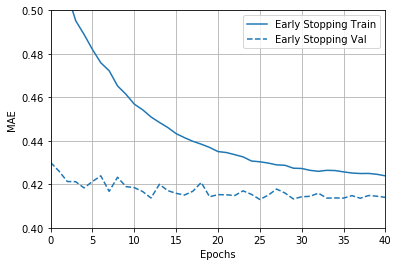

In [47]:
# Plotting change in MAE with increasing number of epochs

plotter = tfdocs.plots.HistoryPlotter()

plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0.4, 0.5])
plt.ylabel('MAE');

In [48]:
loss, mae, mse = keras_clf.evaluate(X_clean, y_clean, verbose=2)
print("Training set Mean Abs Error: {:5.8f}".format(mae))

188318/188318 - 8s - loss: 0.4038 - mae: 0.4038 - mse: 0.2801
Training set Mean Abs Error: 0.40383509


In [49]:
print('min val_mae:', np.min(early_hist['val_mae']))
print('avg val_mae:', np.mean(early_hist['val_mae'][-15:]))

min val_mae: 0.41303807497024536
avg val_mae: 0.4146371146043142


In [50]:
# keras predictions on the train data
y_pred_keras = keras_clf.predict(X_clean).flatten()

# Saving keras predictions on the test data
y_test_keras = keras_clf.predict(X_test_clean).flatten()
output = pd.DataFrame({'id': X_test_clean.index, 
                       'loss': np.expm1(y_test_keras)})
output.to_csv('./output/submission_keras.csv', index=False)

In [51]:
print('keras training score:',mean_absolute_error(np.expm1(y_pred_keras),np.expm1(y_clean)))
print('keras training MAE:',np.mean(np.abs(y_pred_keras-y_clean)))

keras training score: 1111.7834652717252
keras training MAE: 0.4038350061375241


# 7. Model Ensembling <a id='section_7'></a>

[7.1 Comparing model fits](#section_7.1)   
[7.2 Voting ensemble](#section_7.2)   
[7.3 Stacking ensemble](#section_7.3)  

##  7.1 Comparing model fits <a id='section_7.1'></a>

In [52]:
models_fit_df

,model,model_clf,mean(CV),std(CV)
0,LGBMRegressor,"LGBMRegressor(boosting_type='gbdt', class_weig...",0.414,0.0002
1,XGBRegressor,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.416,0.0004


Scoring on the Kaggle private leaderboard, calculated using 70% of the test data:
- LGBMRegressor: 1135.47485
- XGBRegressor:  1135.67412
- Keras:         1150.33700

## 7.2 Voting ensemble <a id='section_7.2'></a>

In [53]:
# Voting predictions on training set
y_pred_voting = ((1.*y_pred_lgb) + (1.*y_pred_xgb) + (1.*y_pred_keras))/3.

# Voting predictions on test set
y_test_voting = ((1.*y_test_lgb) + (1.*y_test_xgb) + (1.*y_test_keras))/3.

# Voting predictions with just lgb and xgb
y_test_voting_lgbxgb = ((1.*y_test_lgb) + (1.*y_test_xgb))/2.

In [54]:
# Saving voting predictions on the test data
output = pd.DataFrame({'id': X_test_clean.index, 
                       'loss': np.expm1(y_test_voting)})
output.to_csv('./output/submission_voting.csv', index=False)

#  Voting predictions with just lgb and xgb
output = pd.DataFrame({'id': X_test_clean.index, 
                       'loss': np.expm1(y_test_voting_lgbxgb)})
output.to_csv('./output/submission_voting_lgbxgb.csv', index=False)

Scoring results:  
Averaging LGB and XGB results with equal weighting:         1133.25998 (top 45%)  
Averaging LGB, XGB, and keras results with equal weighting: 1129.37730 (top 37%)

## 7.3 Stacking ensemble <a id='section_7.3'></a>

In [55]:
# Creating a dataframe of the predicted values

# Training set predictions
y_pred_df = pd.DataFrame()
y_pred_df['lgb'] = y_pred_lgb
y_pred_df['xgb'] = y_pred_xgb
y_pred_df['keras'] = y_pred_keras

# Test set predictions
y_test_df = pd.DataFrame()
y_test_df['lgb'] = y_test_lgb
y_test_df['xgb'] = y_test_xgb
y_test_df['keras'] = y_test_keras

In [56]:
from sklearn.linear_model import Ridge

stacking_clf = Ridge(alpha=189).fit(y_pred_df,y_clean)

print(stacking_clf.coef_)

[0.82756237 0.06142018 0.14816301]


In [57]:
# Stacking predictions on training data
y_pred_stacking = stacking_clf.predict(y_pred_df)

# Stacking predictions on test data
y_test_stacking = stacking_clf.predict(y_test_df)

# Saving stacking predictions on the test data
output = pd.DataFrame({'id': X_test_clean.index, 
                       'loss': np.expm1(y_test_stacking)})
output.to_csv('./output/submission_stacking.csv', index=False)

Scoring results:  
Stacking ensemble of LGB, XGB, keras with Ridge as meta-model: 1128.77685 (top 36%)